In [1]:
import h5py
import psana
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import  rotate
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit,minimize
import multiprocessing
import os
from functools import partial
import time
import sys
import argparse
from datetime import datetime
import tempfile
import XSpect.XSpect_Analysis
import XSpect.XSpect_Controller
import XSpect.XSpect_Visualization

## Viewing Static XES Spectra

In [2]:
xes_experiment = XSpect.XSpect_Analysis.spectroscopy_experiment(hutch='mfx',experiment_id='mfx100894224',lcls_run=24)
xes=XSpect.XSpect_Controller.XESBatchAnalysisRotation()
keys=['tt/fltpos_ps','epics/lxt', 'scan/mfx_lxt_fast1' , 'MfxDg2BmMon/totalIntensityJoules','tt/ampl'] 
#keys=['tt/fltpos_ps','epics/lxt', 'scan/lxt' , 'MfxDg2BmMon/totalIntensityJoules','tt/ampl'] 
names=['time_tool_correction','lxt_ttc', 'encoder','ipm', 'time_tool_ampl']
#Here we define the epix detector keys separately as they are imported separately to avoid OOM
xes.key_epix=['epix100/ROI_area']
xes.friendly_name_epix=['epix']
##
xes.set_key_aliases(keys,names)
#xes.end_index=5000
# xes.mintime=-87E-12
# xes.maxtime=-85E-12

# xes.mintime=-5.0E-12
# xes.maxtime=5.0E-12

xes.mintime=-20
xes.maxtime=20
xes.hitfind=True
xes.numpoints=50
xes.time_bins=np.linspace(xes.mintime,xes.maxtime,xes.numpoints)
#xes.rois=[[0,50]]
xes.adu_cutoff=3.0
#xes.angle=90
xes.lxt_key=None
xes.transpose=False
#xes.add_filter('xray','ipm4',1.0E3)
#xes.add_filter('simultaneous','ipm4',1.0E3)
#xes.add_filter('simultaneous','time_tool_ampl',0.05)
#xes.run_parser(['23'])
xes.run_parser(['46-49'])

In [3]:
#start=time.time()
xes.primary_analysis_parallel_range(4,xes_experiment,increment=500,verbose=False)
#end=time.time()

Processing: 100%|██████████| 73/73 [00:10<00:00,  6.65Shot_Batch/s]


In [4]:
xes.analyzed_runs[0].status

['New analysis of run 46 located in: /sdf/data/lcls/ds/mfx/mfx100894224/hdf5/smalldata/mfx100894224_Run0046.h5',
 'HDF5 import of keys completed. Time: 0.01 seconds',
 'HDF5 import of keys completed. Time: 0.11 seconds',
 'Obtained shot properties',
 'Key: epix has been adu filtered by threshold: 3.000000',
 'Starting hit finding',
 'Hit finding on epix. Hits found: 356, median intensity: 12249.109740000002, std: 1963.355787370353, threshold: 10285.75395262965',
 'Applying Hits to ePix detector. New size 356',
 'Shots combined for detector epix on filters: simultaneous and laser into epix_simultaneous_laser',
 'Shots (49) separated for detector epix on filters: xray and laser into epix_xray_laser',
 'Generated timing bins from -20.000000 to 20.000000 in 50 steps.',
 'Shots combined for detector timing_bin_indices on filters: simultaneous and laser into timing_bin_indices_simultaneous_laser',
 'Shots (49) separated for detector timing_bin_indices on filters: xray and laser into timing_b

In [5]:
xes.parse_run_shots(xes_experiment)

In [6]:
xes.aggregate_statistics()

In [7]:
xes.print_run_statistics()

Run Number: 46
  Total: 11976
  X-ray Total: 11890
  Laser Total: 10267
  XES_Hits: 9798
  Percent_XES_Hits: 81.81%

Run Number: 47
  Total: 11976
  X-ray Total: 11885
  Laser Total: 10268
  XES_Hits: 9804
  Percent_XES_Hits: 81.86%

Run Number: 48
  Total: 239
  X-ray Total: 237
  Laser Total: 204
  XES_Hits: 204
  Percent_XES_Hits: 85.36%

Run Number: 49
  Total: 11736
  X-ray Total: 11652
  Laser Total: 10057
  XES_Hits: 9627
  Percent_XES_Hits: 82.03%



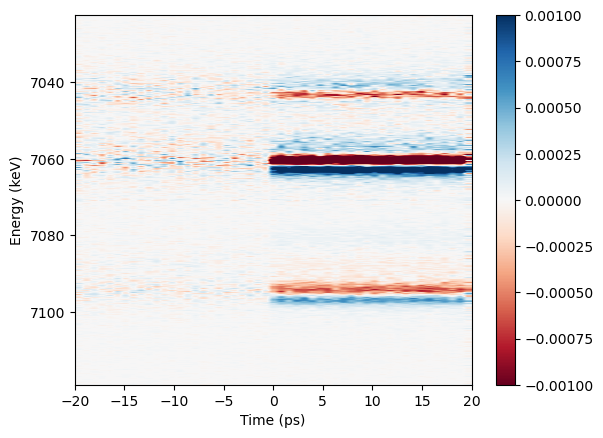

In [8]:
v=XSpect.XSpect_Visualization.XESVisualization()
v.combine_spectra(xes_analysis=xes,xes_key='epix_xray_not_laser_time_binned_ROI_1',
                  xes_laser_key='epix_simultaneous_laser_time_binned_ROI_1')
                  #dark_cutoff=10)
v.vmin=-0.001
v.vmax=0.001
v.plot_2d_difference_spectrum(xes)
#plt.xlim(-0.8,0.8)
#print('Run 23 Laser on shots - Laser off shots')

In [9]:
xes.time_bins

array([-20.        , -19.18367347, -18.36734694, -17.55102041,
       -16.73469388, -15.91836735, -15.10204082, -14.28571429,
       -13.46938776, -12.65306122, -11.83673469, -11.02040816,
       -10.20408163,  -9.3877551 ,  -8.57142857,  -7.75510204,
        -6.93877551,  -6.12244898,  -5.30612245,  -4.48979592,
        -3.67346939,  -2.85714286,  -2.04081633,  -1.2244898 ,
        -0.40816327,   0.40816327,   1.2244898 ,   2.04081633,
         2.85714286,   3.67346939,   4.48979592,   5.30612245,
         6.12244898,   6.93877551,   7.75510204,   8.57142857,
         9.3877551 ,  10.20408163,  11.02040816,  11.83673469,
        12.65306122,  13.46938776,  14.28571429,  15.10204082,
        15.91836735,  16.73469388,  17.55102041,  18.36734694,
        19.18367347,  20.        ])

In [10]:
off = xes.analyzed_runs[2].epix_xray_not_laser_time_binned_ROI_1 
on = xes.analyzed_runs[2].epix_simultaneous_laser_time_binned_ROI_1

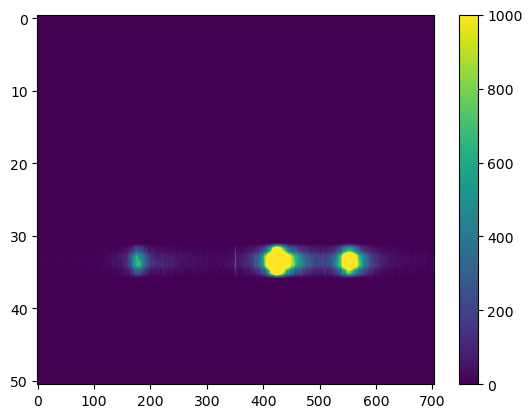

In [11]:
plt.imshow(off, aspect="auto")
plt.clim(0, 1000)
plt.colorbar()

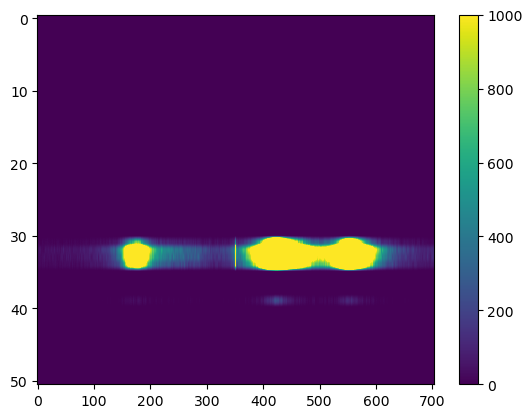

In [12]:
plt.imshow(on, aspect='auto')
plt.clim(0, 1000)
plt.colorbar()

In [13]:
xes.summed_laser_off_normalized

array([[4.49998686e-05, 2.37736707e-05, 2.64606999e-05, ...,
        8.46072414e-05, 1.31146060e-04, 6.43768015e-05],
       [5.19356032e-05, 5.92201968e-05, 2.80451432e-05, ...,
        1.02597442e-04, 1.49365889e-04, 1.04602239e-04],
       [3.94449791e-05, 5.81109664e-05, 3.40812459e-05, ...,
        9.69747372e-05, 1.20327973e-04, 8.31990527e-05],
       ...,
       [4.29306566e-05, 2.43437524e-05, 3.08894631e-05, ...,
        1.69655631e-04, 1.26969221e-04, 6.37049763e-05],
       [4.22727898e-05, 4.70550308e-05, 3.39879952e-05, ...,
        7.81954080e-05, 1.25730845e-04, 1.21409061e-04],
       [5.77515791e-05, 3.35029629e-05, 5.55325886e-05, ...,
        5.99302209e-05, 4.60036106e-05, 1.49546830e-04]])

In [14]:
xes.summed_laser_on_normalized

array([[3.75766171e-05, 5.18381952e-05, 3.89243617e-05, ...,
        9.52306889e-05, 1.16907868e-04, 1.07957255e-04],
       [4.30015844e-05, 4.06187704e-05, 4.63143656e-05, ...,
        8.33416961e-05, 9.84812642e-05, 1.14886370e-04],
       [5.04153365e-05, 5.36702321e-05, 3.36129472e-05, ...,
        1.04121259e-04, 1.06602748e-04, 1.02132028e-04],
       ...,
       [4.88501554e-05, 3.57268808e-05, 4.41598417e-05, ...,
        9.07410785e-05, 1.06495283e-04, 1.15002867e-04],
       [3.70012942e-05, 6.06798284e-05, 3.18246609e-05, ...,
        1.15590269e-04, 1.32148274e-04, 1.12822904e-04],
       [1.19034076e-04, 6.13312666e-05, 0.00000000e+00, ...,
        3.87368428e-05, 2.16118929e-04, 8.55959577e-05]])

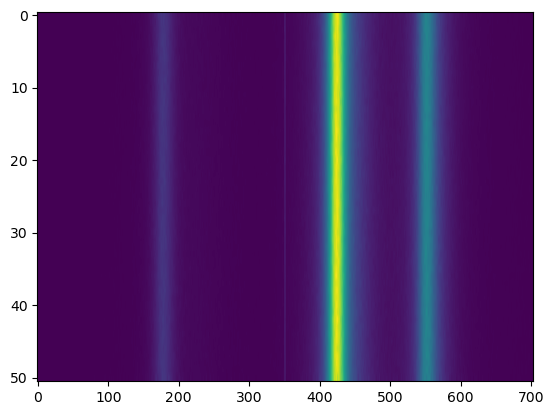

In [15]:
plt.imshow(xes.summed_laser_off_normalized, aspect = 'auto')

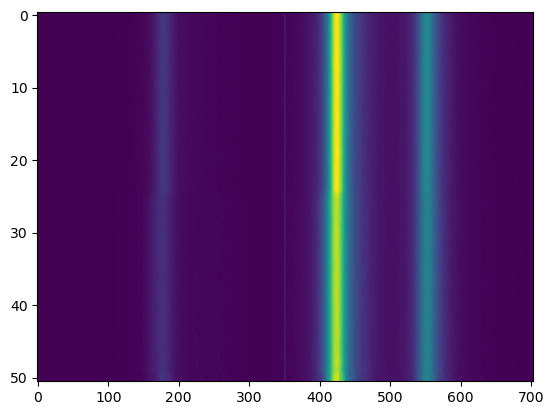

In [16]:
plt.imshow(xes.summed_laser_on_normalized, aspect = 'auto')

In [17]:
file_path = '/sdf/data/lcls/ds/mfx/mfx100894224/hdf5/smalldata/mfx100894224_Run0046.h5'

In [18]:
!ls -lrt /sdf/data/lcls/ds/mfx/mfx100894224/hdf5/smalldata/mfx100894224_Run0043.h5

-rw-rw----+ 1 dorlhiac ps-data 250875193 May  4 12:02 /sdf/data/lcls/ds/mfx/mfx100894224/hdf5/smalldata/mfx100894224_Run0043.h5


In [19]:
file = h5py.File(file_path, 'r')

In [20]:
list(file.keys())

['MfxDg1BmMon',
 'MfxDg2BmMon',
 'Sums',
 'UserDataCfg',
 'damage',
 'ebeamh',
 'epics',
 'epics_archiver',
 'epix100',
 'feespec',
 'gasdet',
 'lightStatus',
 'pcav',
 'qadc_ch0',
 'qadc_ch1',
 'scan',
 'timestamp',
 'timing',
 'tt']

In [21]:
def printnames(name):
    print(name)

file.visit(printnames)

MfxDg1BmMon
MfxDg1BmMon/peakAmplitude
MfxDg1BmMon/peakTime
MfxDg1BmMon/totalIntensityJoules
MfxDg1BmMon/xPositionMeters
MfxDg1BmMon/yPositionMeters
MfxDg2BmMon
MfxDg2BmMon/peakAmplitude
MfxDg2BmMon/peakTime
MfxDg2BmMon/totalIntensityJoules
MfxDg2BmMon/xPositionMeters
MfxDg2BmMon/yPositionMeters
Sums
Sums/epix100_calib
Sums/epix100_calib_dropped
Sums/epix100_calib_max
Sums/epix100_calib_thresADU1
Sums/jungfrau_calib
Sums/jungfrau_calib_dropped
Sums/jungfrau_calib_max
Sums/jungfrau_calib_thresADU1
UserDataCfg
UserDataCfg/MfxDg1BmMon
UserDataCfg/MfxDg1BmMon/detname
UserDataCfg/MfxDg1BmMon/name
UserDataCfg/MfxDg2BmMon
UserDataCfg/MfxDg2BmMon/detname
UserDataCfg/MfxDg2BmMon/name
UserDataCfg/ebeamh
UserDataCfg/ebeamh/detname
UserDataCfg/ebeamh/name
UserDataCfg/epics
UserDataCfg/epics/PV_0
UserDataCfg/epics/PV_1
UserDataCfg/epics/PV_2
UserDataCfg/epics/PVname_0
UserDataCfg/epics/PVname_1
UserDataCfg/epics/PVname_2
UserDataCfg/epics/detname
UserDataCfg/epics/name
UserDataCfg/epix100
UserDataCf

In [22]:
laser_status = file['lightStatus/laser']
xray_status = file['lightStatus/xray']

In [23]:
laser_status.shape

(12000,)

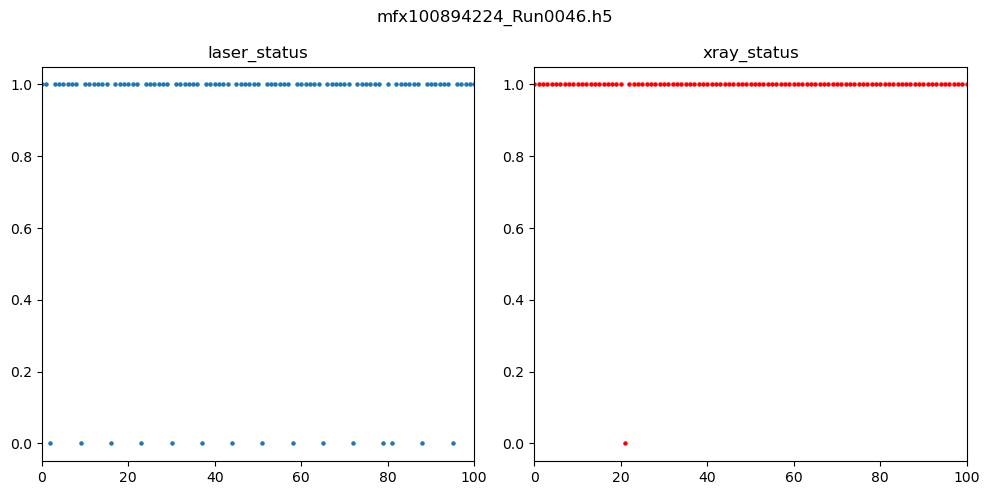

In [24]:
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.scatter(np.arange(len(laser_status)),laser_status, s=5)
plt.xlim(0, 100)
plt.title("laser_status")

plt.subplot(1, 2, 2)
plt.scatter(np.arange(len(xray_status)),xray_status, s=5, color = 'r')
plt.xlim(0, 100)
plt.title("xray_status")

plt.suptitle(file_path[-23:])

plt.tight_layout()

In [25]:
lxt_ttc = file['epics/lxt']

0.0

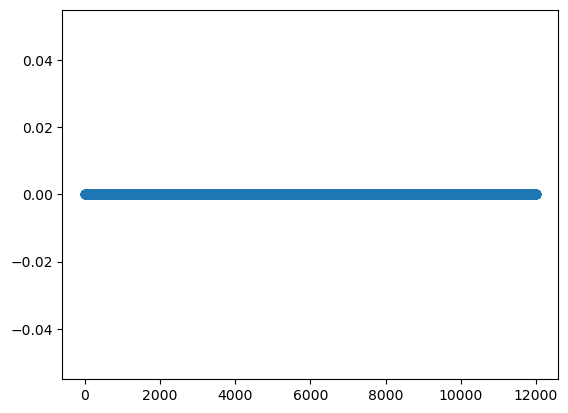

In [26]:
plt.scatter(np.arange(len(lxt_ttc)), lxt_ttc)
np.average(lxt_ttc)

In [27]:
lxt_encoder = file['scan/mfx_lxt_fast1']

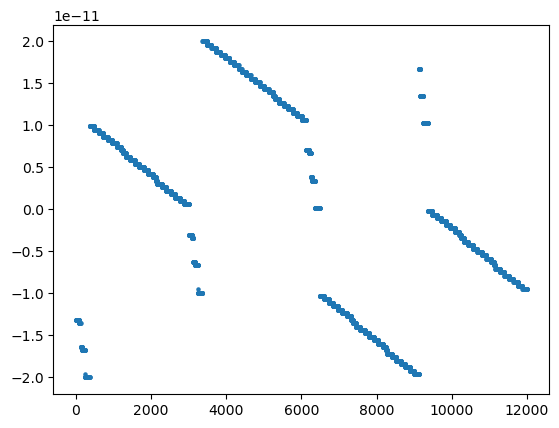

In [28]:
plt.scatter(np.arange(len(lxt_encoder)), lxt_encoder, s = 5)

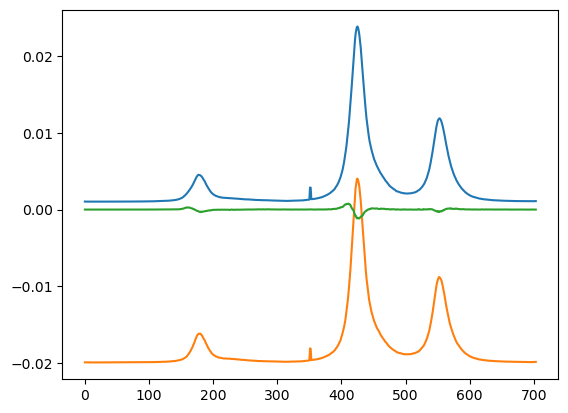

In [29]:
on=np.nanmean(v.summed_laser_on_normalized,axis=0)
off=np.nanmean(v.summed_laser_off_normalized,axis=0)
plt.plot(on+0.001)
plt.plot(off-0.02)
plt.plot(on-off)

Text(0, 0.5, '$\\Delta$ XES')

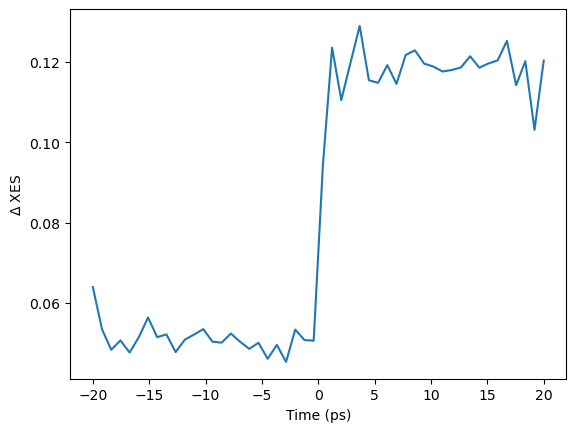

In [30]:
times=np.linspace(xes.mintime,xes.maxtime,xes.numpoints)
diff=np.nansum(np.abs(v.summed_laser_on_normalized-v.summed_laser_off_normalized),axis=1)[:-1]
plt.plot(times,diff)
plt.xlabel('Time (ps)')
plt.ylabel(r'$\Delta$ XES')


In [31]:
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d
times=np.linspace(xes.mintime,xes.maxtime,xes.numpoints)
diff=np.nansum(np.abs(v.summed_laser_on_normalized-v.summed_laser_off_normalized),axis=1)[:-1]
smooth=False
interpolate=False
def error_function(x, a, b, c, d):
    return a * (1 + scipy.special.erf(b * (x - c))) + d

def gaussian(x, amplitude, center, fwhm, offset):
    sigma = fwhm / (2 * np.sqrt(2 * np.log(2)))
    return amplitude * np.exp(-(x - center)**2 / (2 * sigma**2)) + offset
initial_guess = [np.max(diff) - np.min(diff), 1E11, np.mean(times), np.min(diff)]
if interpolate:
    num_interpolated_points = len(times) * 10  # Increase the number of points by a factor of 10
    interpolator = interp1d(times, diff, kind='cubic', fill_value='extrapolate')
    times = np.linspace(times[0], times[-1], num_interpolated_points)
    diff = interpolator(times)

if smooth:
    diff=savgol_filter(diff, window_length=10, polyorder=9)
params, covariance = curve_fit(error_function, times, diff, p0=initial_guess, maxfev=99999999)

fig, axs = plt.subplots(2, 1, sharex=True, dpi=150)
fwhm = np.abs(2 * np.sqrt(2 * np.log(2)) / params[1])
grad = np.gradient(smoothed_diff, times[1] - times[0])
#grad = np.diff(diff) / np.diff(times)

axs[1].plot(times, grad, label='Data Gradient')
axs[0].plot(times, diff, label='Data')
axs[1].set_xlabel('Position')
axs[1].set_ylabel('Intensity')
# axs[0].set_title(f'Wire Scan Run {run}; Fitted FWHM = {fwhm*1000:,.3f} microns')
axs[1].plot(times,  gaussian(times, np.max(np.abs(grad)), params[2], fwhm, 0), label='Gaussian Fit')
axs[1].set_title('Derivative')

# Plot the error function fit
axs[0].plot(times, error_function(times, *params), label='Error Function Fit')
axs[0].legend()
axs[1].legend()
plt.tight_layout()
plt.show()

print("Fitted parameters for the error function:")
#print(f"Amplitude (a): {params[0]} - This controls the vertical stretch of the error function.")
#print(f"Slope (b): {params[1]} - This influences the steepness of the transition edge.")
#print(f"Center (c): {params[2]} - This is the horizontal position of the center of the error function.")
#print(f"Offset (d): {params[3]} - This is the vertical offset of the error function.")
print(f"FWHM: {fwhm*1E15} - This is the full width at half maximum of the instrument response function (IRF).")


NameError: name 'scipy' is not defined